# Baseline model

Using only the rides data, compute the average count for each (grid, weekday, hour).
It can be trained on data for a whole month on a local machine.

TODO:
- Include weather data


### Stats:

Train on 2014/01-12 small; predict on 2015/01-12 small (at the bottom of this notebook):
- scaled RMSE:  0.031028932423957583
- RMSE:  4.0838978039637
- R^2 : 0.9042835809626917
- Residual stats: mean -0.092445; std 4.082855

For 2014 small:
- 01m34s to train and predict
- RMSE: train = 0.9156017914056118, test = 1.2870523791596795
- R2: train = 0.5844674600403812, test = 0.177329259197809

2014-01-mid (3,000,000 rows):
- 01m35s
- max(train.count) = 361, max(test.count) = 358
- RMSE: training = 0.0271, test = 0.0277; corresponds to training = 9.45, test = 9.96
- R^2: training = 0.930, test = 0.918
- Residual: mean = -0.110, stddev = 9.96

2014-01-full
- 05m01s to train
- max(train.count) = 1503, max(test.count) = 1521,
- RMSE (scaled): train = 0.021604257260521623, test = 0.021697862672903957,
- RMSE: train = 32.47119866256401, test = 32.950951822140695
- R^2: train = 0.9447414064723766, test = 0.9431829009300784
- residual mean = -0.085320, stddev = 32.950987

Prediction on 2015-01 full:
- There is a clear bias along y=-x. Probably due to unobserved cells in 2014.
- scaled RMSE:  0.023446783264938847
- RMSE:  132.85654941659212
- R^2 : 0.7012016196175728
- Residual stats:  mean -43.342647; std 125.588208

In [1]:
import pandas as pd
import numpy as np
from utils import datautils, modelutils

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# warnings are due to slicing done in datautils functions.
# Since original DataFrames don't need to be modified, warnings can be ignored.
pd.options.mode.chained_assignment = None 

In [4]:
# 3m24s for 2014 small
# Reading the files into DataFrames is the bottleneck, so calling pd.concat
# for each DataFrame read adds a negligible amount of delay; in addition, this approach is more space efficient.

def get_rides(year, size):
    df_list = [datautils.get_rides_data(year, m+1, size) for m in range(12)]
    rides = datautils.read_rides(df_list[0])
    for i in range(1,12):
        rides = pd.concat([rides, datautils.read_rides(df_list[i])])
    print(f"Read {len(rides)} rides.")
    return rides
        
def get_metar(year):
    df_list = [datautils.get_metar_data(year, m+1) for m in range(12)]
    metar = datautils.read_metar(df_list[0])
    for i in range(1,12):
        metar = pd.concat([metar, datautils.read_metar(df_list[i])])
    print(f"Read {len(metar)} metar rows.")
    return metar
        

In [3]:
class BaselineModel:
    def __init__(self):
        self.mean_counts = None
        self.mean_scaled_counts = None
        
    def _extract_datetime(self, df):
        df['weekday'] = df['pickup_datetime'].dt.weekday
        df['hour'] = df['pickup_datetime'].dt.hour
        return df
    
    
    # takes a DataFrame transformed with BaselineModel.get_scaled_counts 
    def fit(self, counts):
        counts = self._extract_datetime(counts)
        grouped = counts.groupby(['grid_x','grid_y','weekday','hour'])
        self.mean_counts = grouped['count'].mean()
        self.mean_scaled_counts = grouped['count_scaled'].mean()
        
    def _predict(self, grid_x, grid_y, weekday, hour, scaled=False):
        # TODO: how does df.at(idx,col) work for multi-indexes?
        try:
            if scaled:
                return self.mean_scaled_counts.loc[(grid_x, grid_y, weekday, hour)]
            else:
                return self.mean_counts.loc[(grid_x, grid_y, weekday, hour)]
        except Exception as e:
            #print(grid_x, grid_y, weekday, hour, scaled)
            return 0
    
    # returns a DataFrame with the actual count and the corresponding predicted value
    def predict(self, counts):
        counts = self._extract_datetime(counts)
        counts['pred'] = counts.apply(
            lambda row: self._predict(row['grid_x'], row['grid_y'], 
                                 row['weekday'], row['hour']), axis=1
        )
        counts['pred_scaled'] = counts.apply(
            lambda row: self._predict(row['grid_x'], row['grid_y'], 
                                 row['weekday'], row['hour'], scaled=True), axis=1
        )
        return counts
        
    @staticmethod
    def get_scaled_counts(df):
        return datautils.scale_counts(datautils.get_counts(df))

    # size(test set) = size(data) * ratio.
    @staticmethod
    def train_test_split(df, ratio=0.5):
        assert 0 < ratio and ratio < 1
        mask= np.random.rand(len(df)) < 1 - ratio
        train = df[mask]
        test = df[~mask]
        return train, test

In [4]:
def fit_transform(rides):
    #train, _ = BaselineModel.train_test_split(rides)
    train = BaselineModel.get_scaled_counts(rides)
    bm = BaselineModel()
    bm.fit(train)
    pred_train = bm.predict(train)
    return pred_train

In [5]:
def analyze_underestimated(threshold):
    fig, axs = plt.subplots(12, 5, figsize=(15,4*12))
    for m in range(1,13):
        rides = datautils.read_rides(datautils.get_rides_data(2014,m,'small'))
        pred_train = fit_transform(rides)
        pred_train['residual'] = pred_train['pred'] - pred_train['count']
        underestimated = pred_train[pred_train.residual < (-threshold) * pred_train['count']]
        print(f'{m:02}', underestimated.shape)
        if underestimated.shape[0] > 0:
            underestimated.plot.scatter('grid_x', 'grid_y', ax=axs[m-1, 0])
            underestimated.pickup_datetime.hist(ax=axs[m-1,1])
            underestimated.hour.hist(ax=axs[m-1, 2])
            underestimated.weekday.hist(ax=axs[m-1, 3])
            counts_by_wk_hr = underestimated.groupby(['weekday','hour']).size().reset_index(name='count')
            sns.heatmap(counts_by_wk_hr.pivot('hour','weekday','count').fillna(0), cmap='Blues', ax=axs[m-1,4])

In [6]:
# analyze count < 20 & residual > 10
def analyze_overestimated():
    fig, axs = plt.subplots(12, 5, figsize=(15,4*12))
    for m in range(1,13):
        rides = datautils.read_rides(datautils.get_rides_data(2014,m,'small'))
        pred_train = fit_transform(rides)
        pred_train['residual'] = pred_train['pred'] - pred_train['count']
        overestimated = pred_train[(pred_train['count'] < 20) & (pred_train.residual > 10)]
        print(f'{m:02}', overestimated.shape)
        if overestimated.shape[0] > 0:
            overestimated.plot.scatter('grid_x', 'grid_y', ax=axs[m-1, 0])
            overestimated.pickup_datetime.hist(ax=axs[m-1,1])
            overestimated.hour.hist(ax=axs[m-1, 2])
            overestimated.weekday.hist(ax=axs[m-1, 3])
            counts_by_wk_hr = overestimated.groupby(['weekday','hour']).size().reset_index(name='count')
            sns.heatmap(counts_by_wk_hr.pivot('hour','weekday','count').fillna(0), cmap='Blues', ax=axs[m-1,4])

## Does weather data contribute to reducing bias or variance?

Plots indicate that datetimes with heavy rain tend to be underestimated.
Those with moderate rain have similar distribution to the base distribution.
To check more rigorously whether the counts distribution of a rain subset coincides with the base distribution,
make Q-Q plots of counts or do a KS test.

The subset with heavy rain was the only one that showed a distribution that differs from the base distribution.

Need to consider seasons.
Rain in the summer is different from rain in the winter.

Precipitation:
- < 0.10 --- light
- 0.10 < < 0.30 --- moderate
- \> 0.30 --- heavy

Temperature:
Use 40F and 80F as boundaries.

### Precipitation

In [49]:
rides = datautils.read_rides(datautils.get_rides_data(2014,2,'small'))
metar = datautils.read_metar(datautils.get_metar_data(2014,2))

In [50]:
rides.shape

(492255, 3)

In [8]:
pred_train = fit_transform(rides)
pred_train.head()

,pickup_datetime,grid_x,grid_y,count,count_scaled,weekday,hour,pred,pred_scaled
0,2014-02-01,2,31,2,0.030769,5,0,1.500000,0.023077
1,2014-02-01,2,32,2,0.030769,5,0,1.666667,0.025641
2,2014-02-01,3,27,2,0.030769,5,0,1.666667,0.025641
3,2014-02-01,3,28,17,0.261538,5,0,19.750000,0.303846
4,2014-02-01,3,29,15,0.230769,5,0,12.500000,0.192308


In [17]:
pred_joined = pd.merge(pred_train, metar, left_on='pickup_datetime', right_on='datetime')
pred_joined['residual'] = pred_joined['pred'] - pred_joined['count']
pred_joined['heavy_rain'] = pred_joined['precip_in'] >= 0.30
pred_joined['moderate_rain'] = (pred_joined['precip_in'] >= 0.10) & (pred_joined['precip_in'] < 0.30)
pred_joined.head()

,pickup_datetime,grid_x,grid_y,count,count_scaled,weekday,hour,pred,pred_scaled,datetime,precip_in,fahrenheit,residual,heavy_rain,moderate_rain
0,2014-02-01,2,31,2,0.030769,5,0,1.500000,0.023077,2014-02-01,0.0,35.96,-0.500000,False,False
1,2014-02-01,2,32,2,0.030769,5,0,1.666667,0.025641,2014-02-01,0.0,35.96,-0.333333,False,False
2,2014-02-01,3,27,2,0.030769,5,0,1.666667,0.025641,2014-02-01,0.0,35.96,-0.333333,False,False
3,2014-02-01,3,28,17,0.261538,5,0,19.750000,0.303846,2014-02-01,0.0,35.96,2.750000,False,False
4,2014-02-01,3,29,15,0.230769,5,0,12.500000,0.192308,2014-02-01,0.0,35.96,-2.500000,False,False


(72, 15)


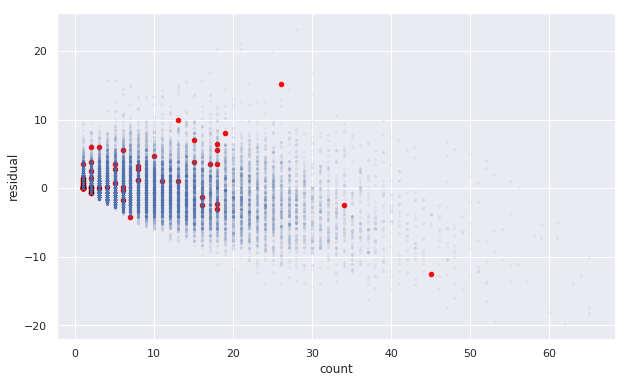

In [42]:
heavy_rain_mask = pred_joined.heavy_rain
heavy_rain = pred_joined[heavy_rain_mask]
others = pred_joined[~heavy_rain_mask]
print(heavy_rain.shape)
fig, ax = plt.subplots(figsize=(10, 6))
heavy_rain.plot.scatter('count','residual',ax=ax, c='red', alpha=1)
others.plot.scatter('count','residual',ax=ax, marker='.', alpha=0.05)

(570, 15)


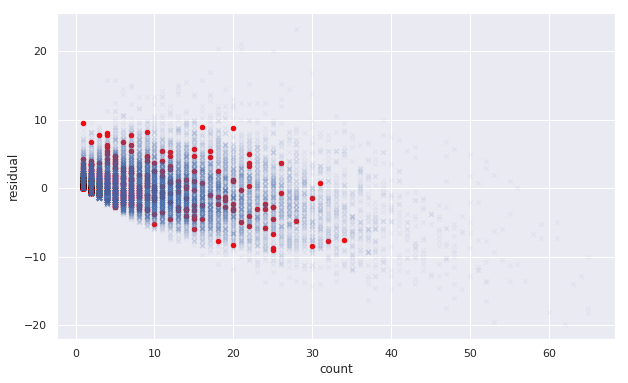

In [37]:
moderate_rain_mask = pred_joined.moderate_rain
moderate_rain = pred_joined[moderate_rain_mask]
others = pred_joined[~moderate_rain_mask]
print(moderate_rain.shape)
fig, ax = plt.subplots(figsize=(10, 6))
moderate_rain.plot.scatter('count','residual',ax=ax, c='red', alpha=1)
others.plot.scatter('count','residual',ax=ax, marker='x', alpha=0.05)

### Temperature

Distributions of points with extreme temperatures are similar to the base distribution.

In [68]:
rides = datautils.read_rides(datautils.get_rides_data(2014,2,'small'))
rides = pd.concat([rides, datautils.read_rides(datautils.get_rides_data(2014,4,'small'))])
rides = pd.concat([rides, datautils.read_rides(datautils.get_rides_data(2014,6,'small'))])
metar = datautils.read_metar(datautils.get_metar_data(2014,2))
metar = pd.concat([metar, datautils.read_metar(datautils.get_metar_data(2014,4))])
metar = pd.concat([metar, datautils.read_metar(datautils.get_metar_data(2014,6))])
pred_train = fit_transform(rides)
pred_joined = pd.merge(pred_train, metar, left_on='pickup_datetime', right_on='datetime')
pred_joined['residual'] = pred_joined['pred'] - pred_joined['count']

In [69]:
metar.shape

(2110, 3)

In [71]:
pred_joined.fahrenheitrenheit.describe()

count    120203.000000
mean         51.811029
std          18.136518
min          10.040000
25%          37.040000
50%          51.080000
75%          68.000000
max          87.080000
Name: fahrenheit, dtype: float64

2521


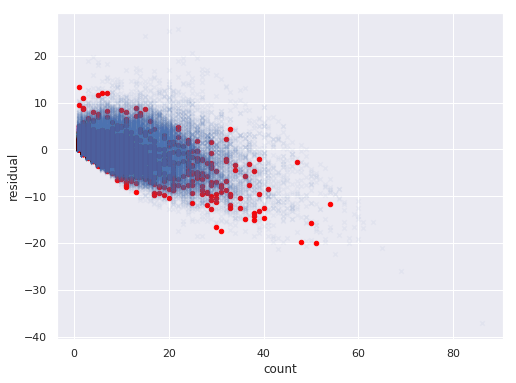

In [84]:
pred_joined['cold'] = pred_joined.fahrenheit < 20
pred_cold = pred_joined[pred_joined.cold]
pred_not_cold = pred_joined[~pred_joined.cold]
print(len(pred_cold))
fig, ax = plt.subplots(figsize=(8, 6))
pred_cold.plot.scatter('count','residual',ax=ax, c='red')
pred_not_cold.plot.scatter('count','residual',ax=ax, marker='x', alpha=0.05)

3767


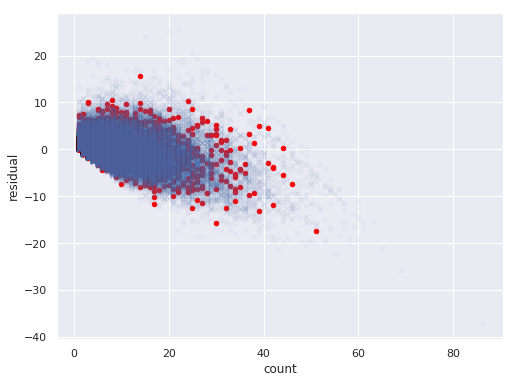

In [83]:
pred_joined['hot'] = pred_joined.fahrenheit > 82
pred_hot = pred_joined[pred_joined.hot]
pred_not_hot = pred_joined[~pred_joined.hot]
print(len(pred_hot))
fig, ax = plt.subplots(figsize=(8, 6))
pred_hot.plot.scatter('count','residual',ax=ax, c='red', alpha=1)
pred_not_hot.plot.scatter('count','residual',ax=ax, marker='x', alpha=0.05)

## Variance in high-demand areas

$grid_x \in [3, 8]$; $grid_y \in [21, 32]$

Both high- and low-demand areas have the same bias.

In [18]:
def high_demand_mask(rides):
    return (rides.grid_x <= 8) & (rides.grid_x >= 3) & \
                     (rides.grid_y <= 32) & (rides.grid_y >= 21)

In [19]:
rides = datautils.read_rides(datautils.get_rides_data(2014,2,'small'))
rides = datautils._add_grid_cols(rides)
high_demand = rides[high_demand_mask(rides)]

In [23]:
# most of the rides are in the high-demand area.
high_demand.shape

(454632, 5)

In [10]:
rides[~high_demand_mask(rides)].shape

(37623, 5)

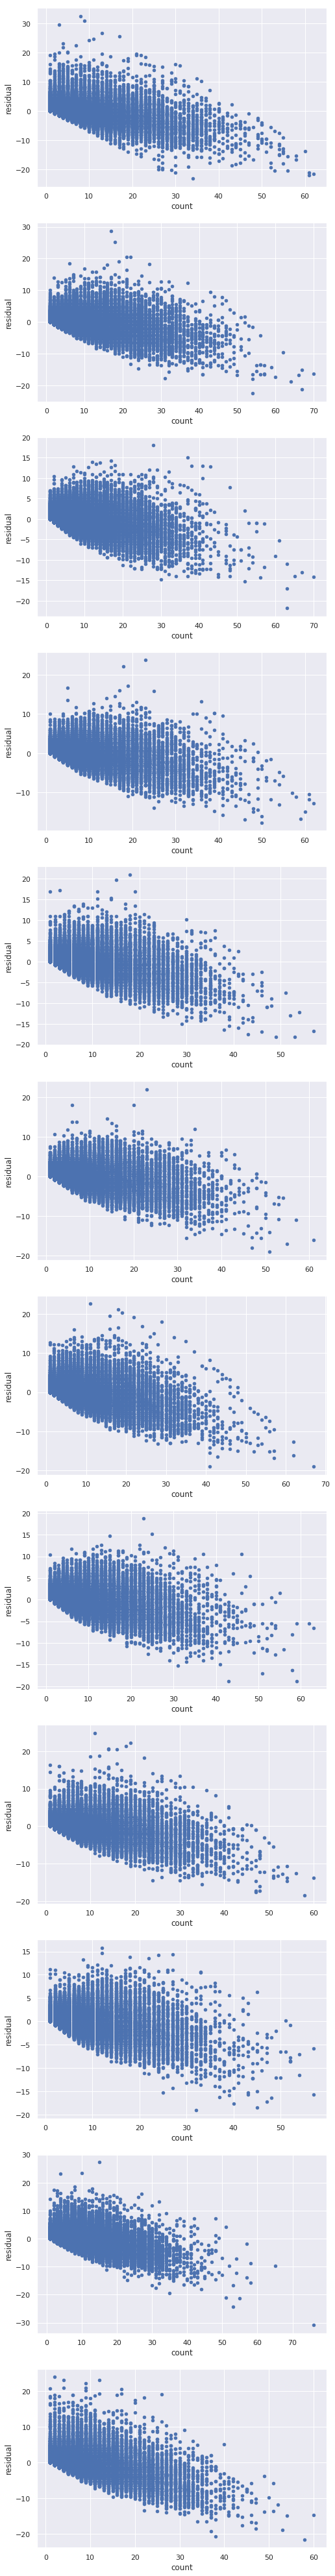

In [22]:
# high-demand area
fig, axs = plt.subplots(12, 1, figsize=(8,6*12))
for m in range(1,13):
    rides = datautils.read_rides(datautils.get_rides_data(2014, m, 'small'))
    rides = datautils._add_grid_cols(rides)
    rides = rides[high_demand_mask(rides)]
    pred = fit_transform(rides)
    pred['residual'] = pred['pred'] - pred['count']
    pred.plot.scatter('count', 'residual', ax=axs[m-1])

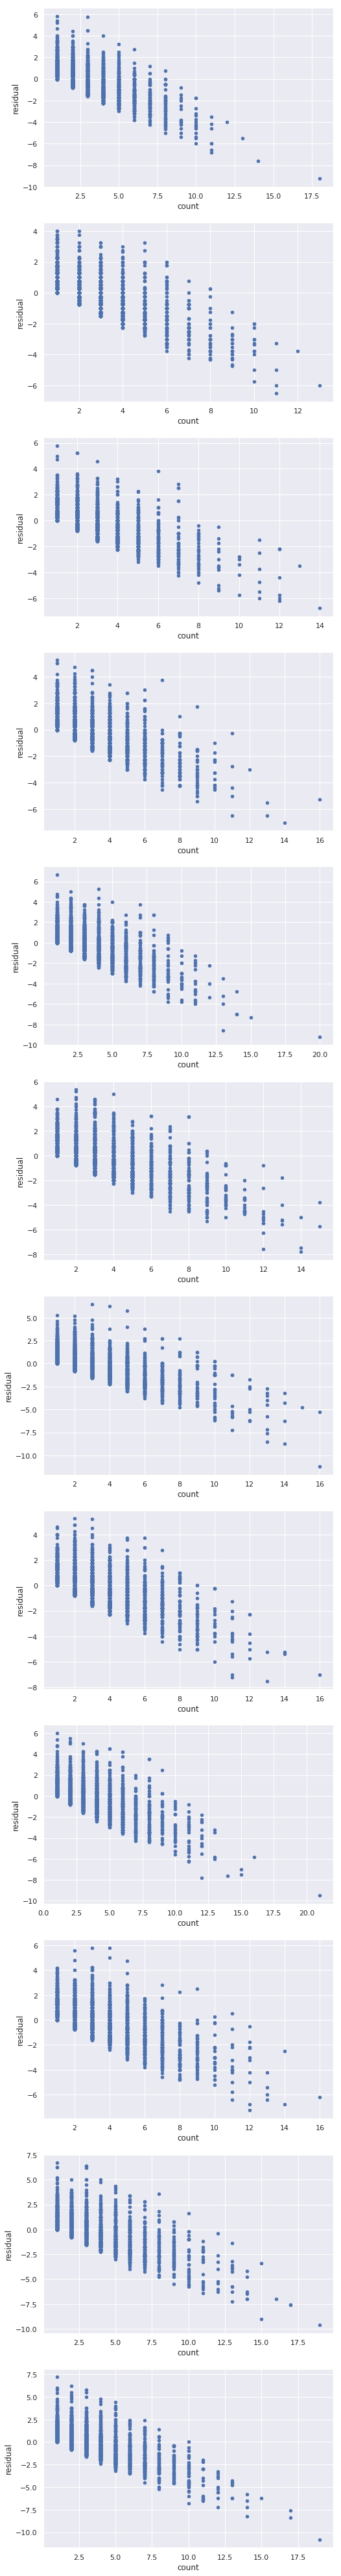

In [24]:
# low-demand area
fig, axs = plt.subplots(12, 1, figsize=(8,6*12))
for m in range(1,13):
    rides = datautils.read_rides(datautils.get_rides_data(2014, m, 'small'))
    rides = datautils._add_grid_cols(rides)
    rides = rides[~high_demand_mask(rides)]
    pred = fit_transform(rides)
    pred['residual'] = pred['pred'] - pred['count']
    pred.plot.scatter('count', 'residual', ax=axs[m-1])

col(count) stats:  count    38774.000000
mean         6.346186
std          7.749649
min          1.000000
25%          1.000000
50%          3.000000
75%          9.000000
max         84.000000
Name: count, dtype: float64

scaled RMSE:  0.0289945868833034

RMSE:  2.435545298197485

R^2 : 0.9012266918806755

Residual stats:  count    3.877400e+04
mean     1.172815e-17
std      2.435577e+00
min     -2.675000e+01
25%     -6.666667e-01
50%      0.000000e+00
75%      7.500000e-01
max      2.225000e+01
Name: residual, dtype: float64
CPU times: user 19.7 s, sys: 99.6 ms, total: 19.8 s
Wall time: 19.9 s


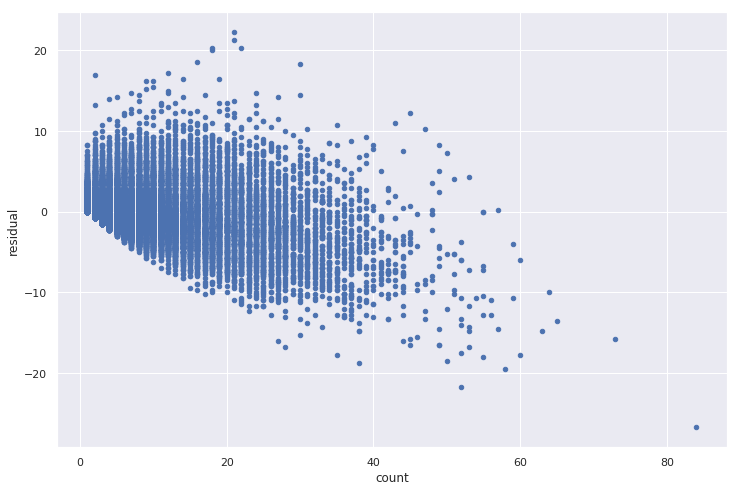

In [129]:
%%time
rides = datautils.read_rides(datautils.get_rides_data(2014,2,'small'))
pred_train = fit_transform(rides)
modelutils.show_prediction_stats(pred_train)

In [131]:
pred_train[pred_train.residual > 20]

,pickup_datetime,grid_x,grid_y,count,count_scaled,weekday,hour,pred,pred_scaled,residual
17634,2014-02-13 22:00:00,6,26,22,0.261905,3,22,42.25,0.502976,20.25
20810,2014-02-16 01:00:00,5,29,18,0.214286,6,1,38.25,0.455357,20.25
23351,2014-02-17 20:00:00,6,26,21,0.250000,0,20,43.25,0.514881,22.25
23417,2014-02-17 21:00:00,6,26,21,0.250000,0,21,42.25,0.502976,21.25


## Analyze over-estimated points

Look at overestimated points satisfying $count < 10$.

Observations:
- Over-estimated points also come from the high-demand area.
- Tends to happen mid-week.
- Tends to happen late-night and early-morning.

01 (227, 10)
02 (73, 10)
03 (24, 10)
04 (26, 10)
05 (53, 10)
06 (22, 10)
07 (99, 10)
08 (29, 10)
09 (83, 10)
10 (28, 10)
11 (137, 10)
12 (258, 10)


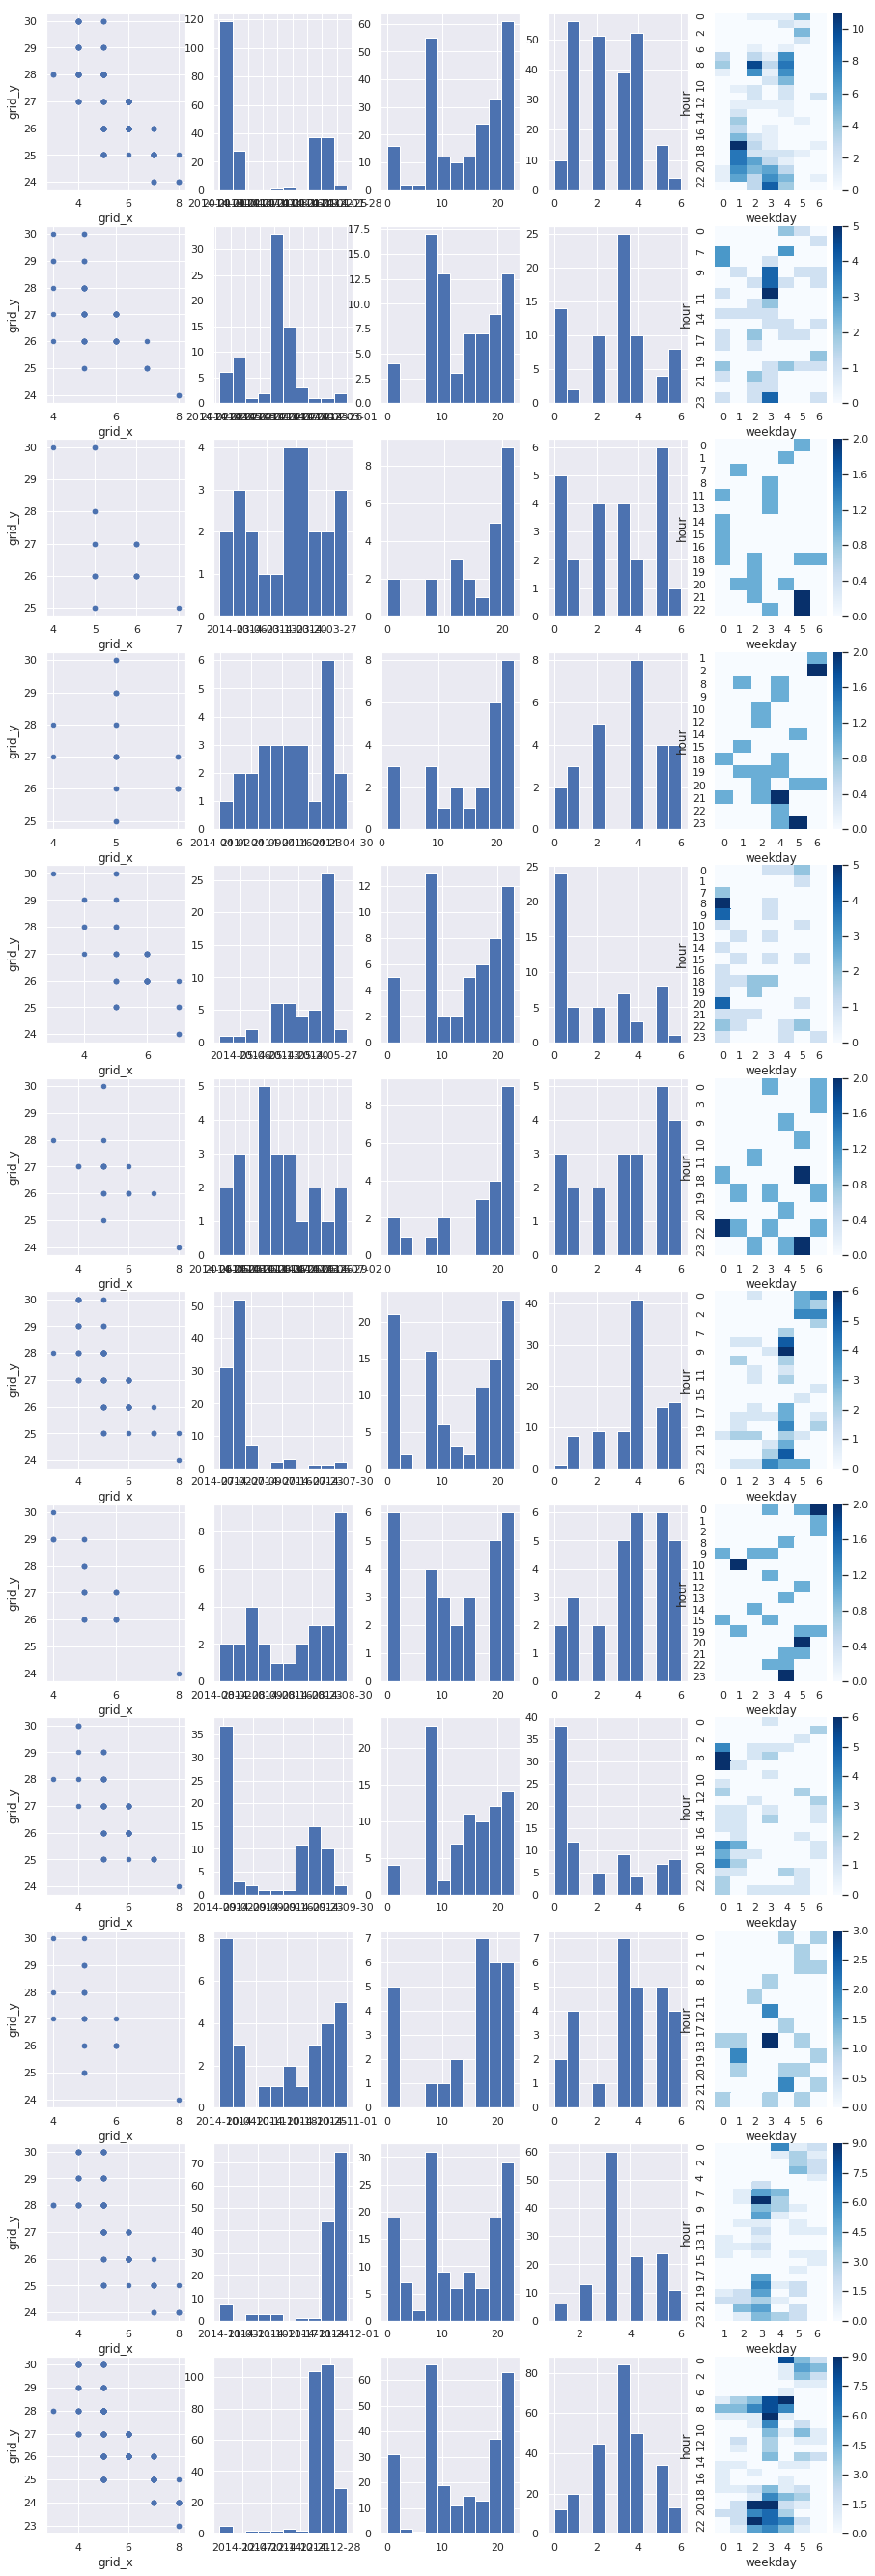

In [147]:
analyze_overestimated()

# Analyze underestimated points --- Take 2

Look at points that satisfy $residual < (-1/2) * count$.

Observations:
- Most of them in the high-demand area, which is approximately $grid_x \in [4,8], grid_y \in [20, 30]$. See Demand Visualization ipynb.
- Plots by hour have spikes around rush hours and at midnight.
    $\rightarrow$ Why should these points be underestimated, when the model does group-by hour and weekday?
    $\rightarrow$ It means these points have high variance. It should be the case that there are equally many (in terms of weights) points that are over-estimated.
- Tends to be in the beginning of a month (01, 08, 09, 11), though not always the case.
    Are they all holidays?
- Some of irregularities are due to one cause. For example, all spikes in the January plots are due to New Years.

In [91]:
%%time
rides = datautils.read_rides(datautils.get_rides_data(2014,2,'small'))
pred_train = fit_transform(rides)

CPU times: user 20.2 s, sys: 26.5 ms, total: 20.2 s
Wall time: 20.2 s


col(count) stats:  count    38643.000000
mean         6.378723
std          7.765410
min          1.000000
25%          1.000000
50%          3.000000
75%          9.000000
max         67.000000
Name: count, dtype: float64

scaled RMSE:  0.03597895003938878

RMSE:  2.4105896526390485

R^2 : 0.9036328562661733

Residual stats:  count    3.864300e+04
mean     1.176791e-17
std      2.410621e+00
min     -1.850000e+01
25%     -6.666667e-01
50%      0.000000e+00
75%      7.500000e-01
max      2.950000e+01
Name: residual, dtype: float64


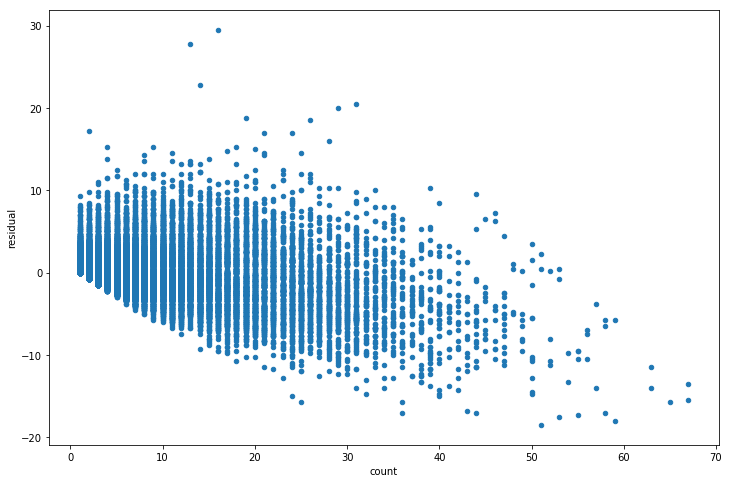

In [92]:
modelutils.show_prediction_stats(pred_train)

01 (372, 10)
02 (171, 10)
03 (242, 10)
04 (205, 10)
05 (244, 10)
06 (230, 10)
07 (259, 10)
08 (242, 10)
09 (263, 10)
10 (207, 10)
11 (294, 10)
12 (284, 10)


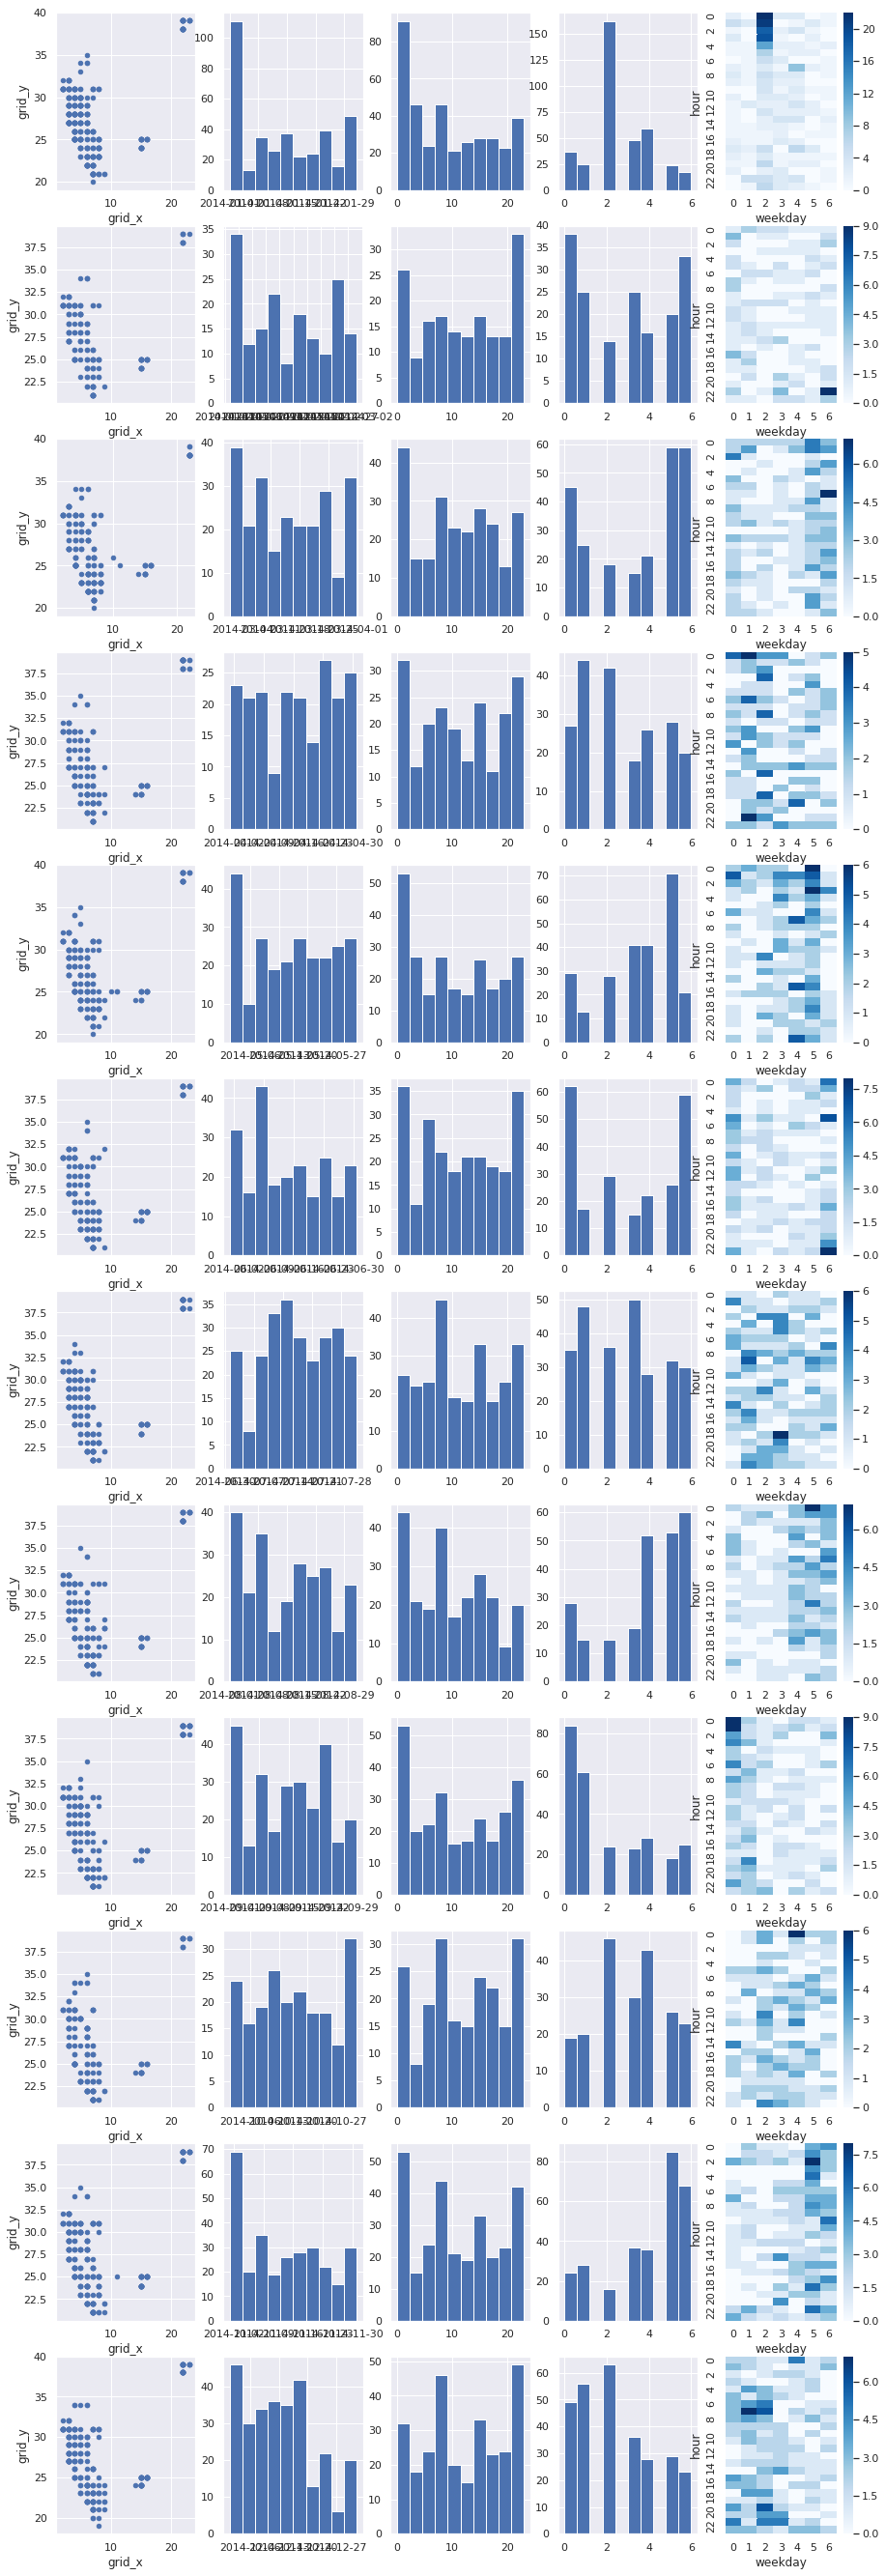

In [146]:
analyze_underestimated(1/2)

## Analyze underestimated points --- Take 1
The 01/01 demand was underestimated because it's a holiday.
Other months don't have many points that match $residual < (-2/3) * count$.

01 (25, 10)
02 (0, 10)
03 (2, 10)
04 (0, 10)
05 (1, 10)
06 (0, 10)
07 (1, 10)
08 (0, 10)
09 (2, 10)
10 (0, 10)
11 (4, 10)
12 (2, 10)


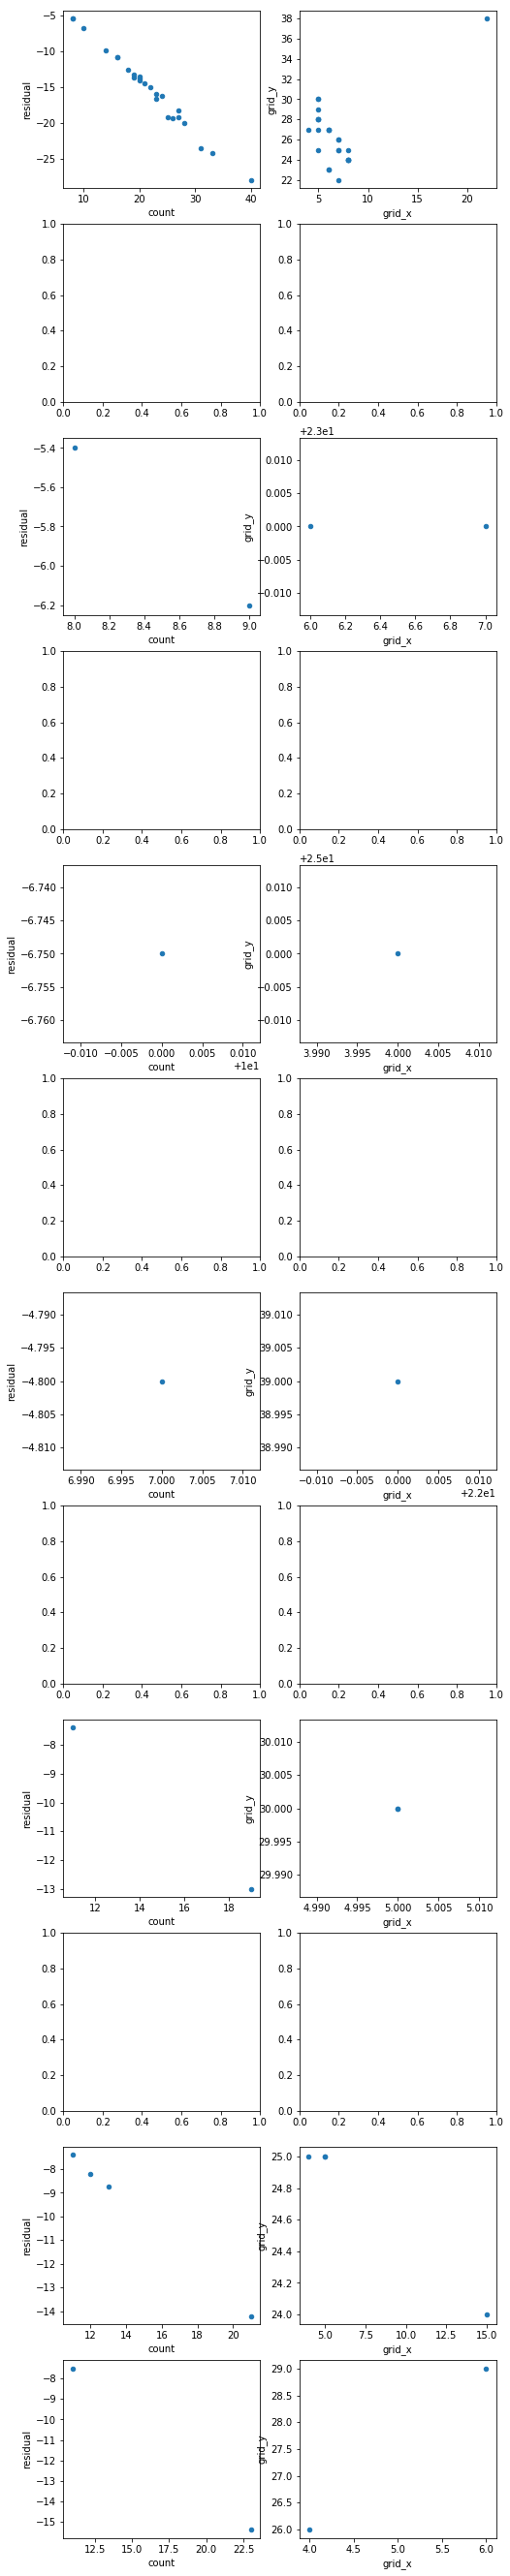

In [98]:
analyze_underestimated(2/3)

In [18]:
pred_train.head()

,pickup_datetime,grid_x,grid_y,count,count_scaled,weekday,hour,pred,pred_scaled,residual
0,2014-01-01,2,32,3,0.046875,2,0,3.000000,0.046875,0.000000
1,2014-01-01,3,27,3,0.046875,2,0,3.333333,0.052083,0.333333
2,2014-01-01,3,28,7,0.109375,2,0,5.000000,0.078125,-2.000000
3,2014-01-01,3,29,5,0.078125,2,0,3.750000,0.058594,-1.250000
4,2014-01-01,3,30,15,0.234375,2,0,5.600000,0.087500,-9.400000


(82, 10)


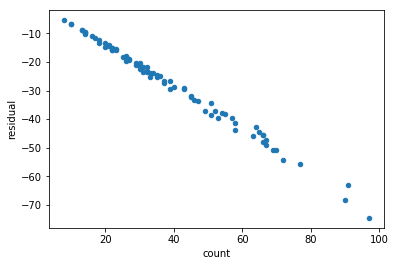

In [42]:
underestimated = pred_train[pred_train.residual < (-2/3) * pred_train['count']]
print(underestimated.shape)
underestimated.plot.scatter('count','residual')

In [64]:
# patterns? -> 01/01 1am-4am.
underestimated

,pickup_datetime,grid_x,grid_y,count,count_scaled,weekday,hour,pred,pred_scaled,residual
23,2014-01-01 00:00:00,5,24,36,0.185567,2,0,11.20,0.057732,-24.80
30,2014-01-01 00:00:00,5,31,8,0.041237,2,0,2.60,0.013402,-5.40
38,2014-01-01 00:00:00,6,23,43,0.221649,2,0,13.60,0.070103,-29.40
55,2014-01-01 00:00:00,7,24,35,0.180412,2,0,9.60,0.049485,-25.40
56,2014-01-01 00:00:00,7,25,45,0.231959,2,0,13.20,0.068041,-31.80
70,2014-01-01 00:00:00,8,23,23,0.118557,2,0,7.20,0.037113,-15.80
71,2014-01-01 00:00:00,8,24,66,0.340206,2,0,20.60,0.106186,-45.40
136,2014-01-01 01:00:00,3,31,34,0.175258,2,1,10.20,0.052577,-23.80
137,2014-01-01 01:00:00,3,32,31,0.159794,2,1,9.20,0.047423,-21.80
142,2014-01-01 01:00:00,4,27,55,0.283505,2,1,16.80,0.086598,-38.20


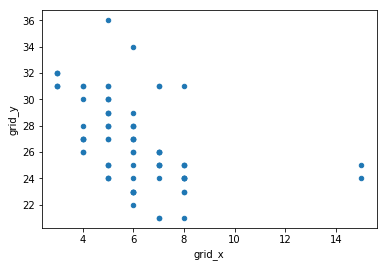

In [44]:
# most of them in 0 <= grid_x <= 8; 22 <= grid_y <= 36
underestimated.plot.scatter('grid_x', 'grid_y')

(31516, 10)


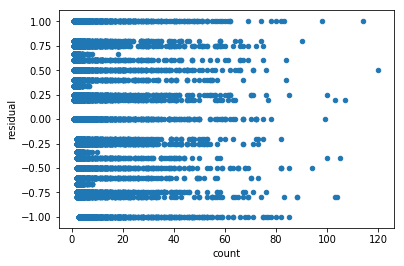

In [46]:
well_estimated = pred_train[np.abs(pred_train.residual) <= 1]
print(well_estimated.shape)
well_estimated.plot.scatter('count','residual')

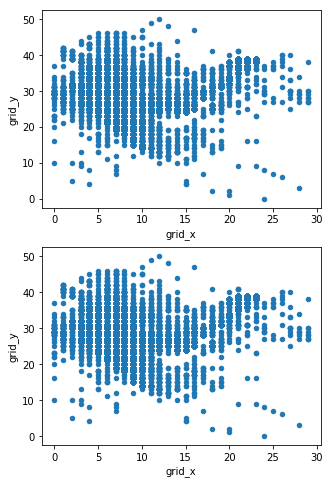

In [57]:
# well-estimated points are distributed no differently from the base distribution.
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(5,8))
well_estimated.plot.scatter('grid_x', 'grid_y', ax = ax1)
pred_train.plot.scatter('grid_x', 'grid_y', ax = ax2)

## Plot residuals


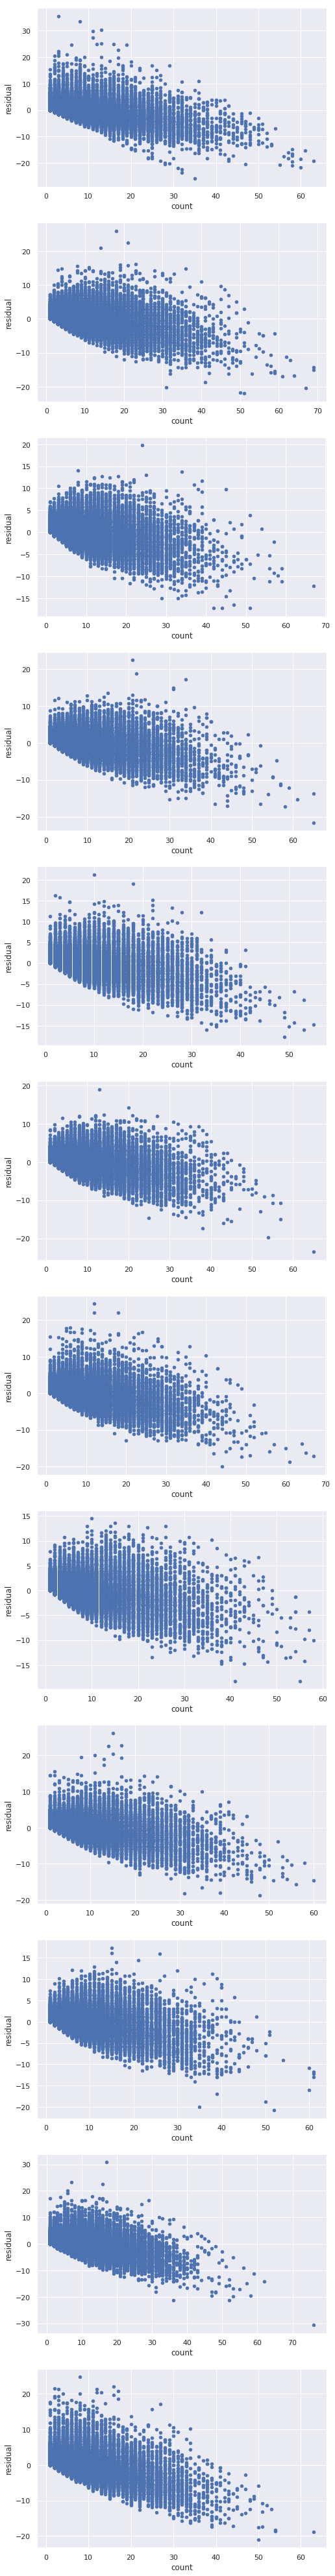

In [136]:
fig, axs = plt.subplots(12, 1, figsize=(8,6*12))
for m in range(1,13):
    rides = datautils.read_rides(datautils.get_rides_data(2014, m, 'small'))
    pred = fit_transform(rides)
    pred['residual'] = pred['pred'] - pred['count']
    pred.plot.scatter('count', 'residual', ax=axs[m-1])

## Train on 2014 small; predict on 2015 small
01m11s to train; 05m11s to predict.

In [5]:
rides_2014 = get_rides(2014, 'small')
rides_2015 = get_rides(2015, 'small')

Read 5878173 rides.


In [8]:
%%time
train = BaselineModel.get_scaled_counts(rides_2014)
bm = BaselineModel()
bm.fit(train)

CPU times: user 1min 9s, sys: 1.54 s, total: 1min 11s
Wall time: 1min 11s


In [9]:
%%time
test = BaselineModel.get_scaled_counts(rides_2015)
pred = bm.predict(test)

CPU times: user 5min 9s, sys: 1.99 s, total: 5min 11s
Wall time: 5min 11s


col(count) stats:  count    606771.000000
mean          9.728822
std          13.200245
min           1.000000
25%           1.000000
50%           3.000000
75%          13.000000
max         135.000000
Name: count, dtype: float64

scaled RMSE:  0.031028932423957583

RMSE:  4.0838978039637

R^2 : 0.9042835809626917

Residual stats:  count    606771.000000
mean         -0.092445
std           4.082855
min         -84.269231
25%          -1.040000
50%           0.111111
75%           1.000000
max          81.576923
Name: residual, dtype: float64


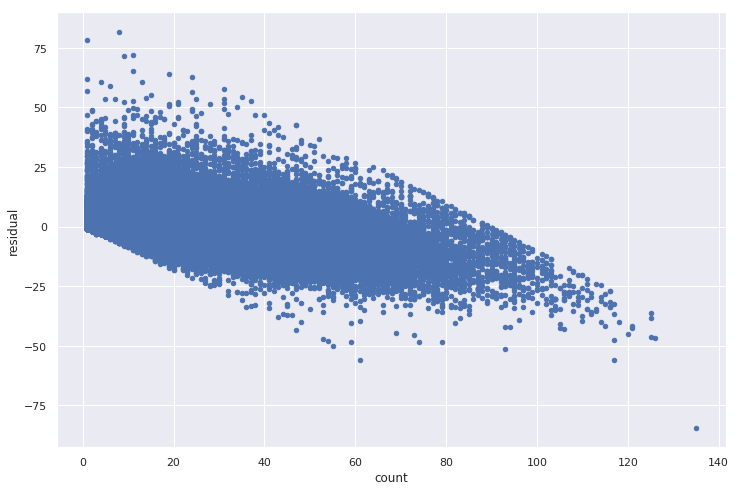

In [10]:
modelutils.show_prediction_stats(pred)